# BBC News predictive algorithm

### Andy McCann 2018/01/18
----
Dataset BBC, raw text files from: D. Greene and P. Cunningham. ["Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering"](http://mlg.ucd.ie/datasets/bbc.html), Proc. ICML 2006

The dataset was also available pre-processed, but as the task asked about preparing the data, I have started from the raw text files and pre-processed here.

I have taken two approaches to this task.  A Support Vector Machine model here in R and further below a Neural Network model in Azure Machine Learning.  If I had more time I would probably have created a Naive Bayes model as others report similar performance using that classifier and it has the benefit of being more transparent and easier to explain to a lay audience.

## Support Vector Machine in R 
To perform this task, I installed Jupyter Data Science Notebook on a Docker swarm which I set up on AWS EC2.

## Install required packages

In [14]:
# for compatability with R v3.3.2 in this notebook, need older versions of Slam and tm
package_url <- "http://cran.r-project.org/src/contrib/Archive/slam/slam_0.1-37.tar.gz"
install.packages(package_url, repos = NULL, type = "source")
package_url <- "https://cran.r-project.org/src/contrib/Archive/tm/tm_0.6-2.tar.gz"
install.packages(package_url, repos = NULL, type = "source")
install.packages('RTextTools')
install.packages('e1071')
library(RTextTools)
library(tm)
library(e1071)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


### Download the ZIPped dataset from the web to a temporary file

In [4]:
temp <- tempfile()                             # get a temporary file name
download.file("http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip",temp)
file_list <- unzip(temp)                       # unzip the files, remembering the list of names
unlink(temp)                                   # and delete the temporary file

### Create a labelled dataframe from the documents

In [5]:
# Ignore the README.TXT file
# The name of the sub-folder containing the file is the category label
# Read all text lines from each document and collapse to single string with lines separated by spaces
# Use lapply to apply to all files and rbind together

dataset <- do.call("rbind",lapply(file_list[basename(file_list)!="README.TXT"],
   FUN=function(file) {data.frame(label = basename(dirname(file)), text = paste(readLines(file),collapse=' '))}))

### Confirm the structure of the dataset

In [6]:
str(dataset)

'data.frame':	2225 obs. of  2 variables:
 $ label: Factor w/ 5 levels "business","entertainment",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ text : Factor w/ 2127 levels "Ad sales boost Time Warner profit  Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three m"| __truncated__,..: 1 2 3 4 5 6 7 8 9 10 ...


### Randomise the dataset (with a set seed, so reproducible)

In [7]:
set.seed(12345)
dataset <- dataset[sample(nrow(dataset)),]

### Examine the first few entries in dataset

In [8]:
head(dataset)

label   
1605 sport   
1948 tech    
1692 sport   
1969 tech    
1014 politics
370  business
     text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
1605 Wales coach elated with win  Mike Ruddock paid tribute to his Wales side after they came from 15-6 down to beat France 24-18 in the Six Nations.  "After going two tries down in 12 minutes we had to show character," said the national team coach. "I didn't have to tell them anything at half-time because those players have stared down the barrel of a gun before. "They decided they didn't want to do that again and came out fighting. It was a great team effort and we showed great character to come back." Man-of-the-match Stephen Jones, who kicked three penalties, a drop goal and conversion, was ecstatic following after the win at Stade de France.  "It's just a special moment. Two years ago we didn't win a single game in the Six Nations. But we're a very happy camp now," he said. "We worked hard as a squad and I'm a proud Welshman

### Preprocess text, remove sparse terms and create a document term matrix.  Set sample split 75:25 train:test.
The text data needs to be converted into a Document Term Matrix in order to train a bag-of-words model, using each word (token) in the text as a feature.

The library tm could be used to stem, remove numbers and so on, but create_matrix does it in one step.  Create_matrix by default converts to lower case, removes punctuation, stop-words and whitespace.

I did also train using TFIDF, but this did not improve the accuracy of the model.

In [9]:
smp_size <- floor(0.75*nrow(dataset))
matrix <- create_matrix(dataset$text, language="english"
 , removeNumbers=TRUE, stemWords=TRUE, removeSparseTerms=.998
 , weighting=weightTf)

SparseTerms setting of 0.998 removes terms which appear in fewer than five documents, reduces the number of features from 21,212 to 6,371 with no resultant effect on F-score

In [10]:
str(matrix)

List of 6
 $ i       : int [1:290002] 1 1 1 1 1 1 1 1 1 1 ...
 $ j       : int [1:290002] 106 185 243 384 432 457 477 683 787 791 ...
 $ v       : num [1:290002] 2 1 1 1 1 1 1 1 2 1 ...
 $ nrow    : int 2225
 $ ncol    : int 6371
 $ dimnames:List of 2
  ..$ Docs : chr [1:2225] "1" "2" "3" "4" ...
  ..$ Terms: chr [1:6371] "aaa" "aaron" "abandon" "abba" ...
 - attr(*, "class")= chr [1:2] "DocumentTermMatrix" "simple_triplet_matrix"
 - attr(*, "weighting")= chr [1:2] "term frequency" "tf"


### Create a container, train a radial SVM model and classify the testing data
Support Vector Machines (SVM) are often used for supervised learning text classification problems.  SVMs are linear discriminants which divide a feature space with a hyperplane (although they often use a kernel function to map the original features to another feature space so creating a non-linear discrminant, as here).

In [11]:
container <- create_container(matrix,dataset$label, trainSize=1:smp_size, testSize=(smp_size+1):nrow(dataset),
virgin=FALSE)


In [39]:
# Defaults
svm_model <- train_model(container, "SVM")
svm_results <- classify_model(container, svm_model)

In [40]:
# combine predicted class with actual class (and document text)
Predictions <- cbind(container@testing_codes, svm_results, dataset[(smp_size+1):nrow(dataset), 'text'])
colnames(Predictions) <- c('Actual', 'Prediction', 'Confidence', 'Document Text')

# find the number of correct and total predictions 
 correct_predictions = sum(Predictions$Actual == Predictions$Prediction)
 total_predictions = nrow(Predictions)
 
cat('\nF-score (micro-averaged):', correct_predictions, '/', total_predictions,'=', correct_predictions / total_predictions, '\n\n')
 
# confusion matrix
 print(table(Predictions[,1:2]), zero.print=".")


F-score (micro-averaged): 539 / 557 = 0.967684 

               Prediction
Actual          business entertainment politics sport tech
  business           135             .        3     .    4
  entertainment        1            88        1     1    1
  politics             .             .      101     .    .
  sport                .             .        2   121    1
  tech                 2             2        .     .   94


### Attempt to tune the model
The SVM radial model with default parameters performs extremely well and achieves a micro-averaged F-score (which for a multi-class problem is the same as the micro-averaged Precision and Recall scores) of 96.8%.

However, attempt to tune the model by doing a grid search of values of gamma (the free parameter of the Gaussian radial function) and cost (the influence of points on the 'wrong' side of the support vector), using 10-fold cross-validation.

In [51]:
model.tuned <- tune.svm(x = container@training_matrix,
                        y = container@training_codes,
                        kernel = "radial",
                        gamma = 10^(-6:-1),
                        cost = 10^(-1:2),
                        )

In [52]:
summary(model.tuned)


Parameter tuning of ‘svm’:

- sampling method: 10-fold cross validation 

- best parameters:
 gamma cost
 1e-05  100

- best performance: 0.02996898 

- Detailed performance results:
   gamma  cost      error dispersion
1  1e-06   0.1 0.77039535 0.02389592
2  1e-05   0.1 0.76919775 0.02629504
3  1e-04   0.1 0.75003607 0.08074179
4  1e-03   0.1 0.24461799 0.04988591
5  1e-02   0.1 0.77398817 0.01954183
6  1e-01   0.1 0.77039535 0.02389592
7  1e-06   1.0 0.77039535 0.02389592
8  1e-05   1.0 0.76739413 0.02747888
9  1e-04   1.0 0.13670731 0.03231720
10 1e-03   1.0 0.04195945 0.01325130
11 1e-02   1.0 0.32787678 0.06036609
12 1e-01   1.0 0.69063920 0.02893785
13 1e-06  10.0 0.76859173 0.02528784
14 1e-05  10.0 0.12891206 0.02913243
15 1e-04  10.0 0.03356901 0.01206664
16 1e-03  10.0 0.03477383 0.01409251
17 1e-02  10.0 0.30090181 0.05489305
18 1e-01  10.0 0.69063920 0.02893785
19 1e-06 100.0 0.12831325 0.02940173
20 1e-05 100.0 0.02996898 0.01165950
21 1e-04 100.0 0.03357261 0.01363795
22

In [53]:
svm_model <- train_model(container,"SVM", kernel="radial", gamma=0.00001, cost=100)
svm_results <- classify_model(container,svm_model)

In [54]:
# combine predicted class with actual class (and document text)
Predictions <- cbind(container@testing_codes, svm_results, dataset[(smp_size+1):nrow(dataset), 'text'])
colnames(Predictions) <- c('Actual', 'Prediction', 'Confidence', 'Document Text')

# find the number of correct and total predictions 
 correct_predictions = sum(Predictions$Actual == Predictions$Prediction)
 total_predictions = nrow(Predictions)
 
cat('\nF-score (micro-averaged):', correct_predictions, '/', total_predictions,'=', correct_predictions / total_predictions, '\n\n')
 
# confusion matrix
 print(table(Predictions[,1:2]), zero.print=".")


F-score (micro-averaged): 539 / 557 = 0.967684 

               Prediction
Actual          business entertainment politics sport tech
  business           134             1        3     .    4
  entertainment        1            88        1     1    1
  politics             .             .      101     .    .
  sport                .             .        2   121    1
  tech                 2             1        .     .   95


In this case, tuning does not improve the overall accuracy compared with the default settings

### Train a linear SVM model
In fact, a linear SVM model performs on this dataset marginally better than a radial model.

In [55]:
svm_model <- train_model(container,"SVM", kernel="linear")
svm_results <- classify_model(container,svm_model)

In [56]:
# combine predicted class with actual class (and document text)
Predictions <- cbind(container@testing_codes, svm_results, dataset[(smp_size+1):nrow(dataset), 'text'])
colnames(Predictions) <- c('Actual', 'Prediction', 'Confidence', 'Document Text')

# find the number of correct and total predictions 
 correct_predictions = sum(Predictions$Actual == Predictions$Prediction)
 total_predictions = nrow(Predictions)
 
cat('\nF-score (micro-averaged):', correct_predictions, '/', total_predictions,'=', correct_predictions / total_predictions, '\n\n')
 
# confusion matrix
 print(table(Predictions[,1:2]), zero.print=".")


F-score (micro-averaged): 541 / 557 = 0.9712747 

               Prediction
Actual          business entertainment politics sport tech
  business           135             .        3     .    4
  entertainment        1            88        1     1    1
  politics             1             .      100     .    .
  sport                .             .        2   122    .
  tech                 2             .        .     .   96


The linear SVM model achieves an accuracy of 97.1% in classifying the 25% of the dataset reserved for testing.  The list below shows the 16 articles in the testing set which are misclassified.

Some could clearly be classified either way.  For example, ths first is an article about the business aspects of technology, while politics and business are often related.

However, the second example is probably picking up on words such as "win" and "commonwealth" and misclassifying an entertainment article as sport. Given more time, it would be interesting to investigate these cases further.

### List the incorrectly labelled articles

In [57]:
Predictions[Predictions$Actual != Predictions$Prediction,]

Actual        Prediction Confidence
5   tech          business   0.9037493 
11  entertainment sport      0.5514630 
16  business      tech       0.8972175 
68  sport         politics   0.8275850 
97  business      politics   0.9065534 
110 business      tech       0.8044108 
147 business      tech       0.8473257 
162 entertainment politics   0.6015395 
290 business      politics   0.6765124 
354 business      politics   0.7798692 
417 politics      business   0.9016291 
453 entertainment tech       0.8713287 
471 tech          business   0.7112088 
493 sport         politics   0.7295576 
503 business      tech       0.6183284 
529 entertainment business   0.5853599 
    Document Text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

It would be interesting to see whether an ensemble method, combining the outputs of a number of different classifiers, could improve further on the accuracy (I had some issues with the kernel dying when I attempted this in the environment I had created).

It would also be interesting to see how accurate a Naive Bayes model would be.  Although the independence assumption is likely to be violated, Naive Bayes models are often used for classifying text where the actual values of the probabilites are not relevant, just the most likely class.  The Naive Bayes classifier has the advantage that it can be relatively easily explained as being based on the product of the evidence lifts of each separate feature, a opposed to other classifiers which are less transparent.

## Neural Network model in Azure Machine Learning

I actually started this task by quickly running a few models in Azure Machine Learning Studio (AML).  I then broke off to create the above analysis to demonstrate that I could address the task using R within a Jupyter notebook.  However, I returned to AML, which allows quick experimentation with different classifiers and parameters and also gives a quick means to operationalise a model by creating an API. 

The input dataset for AML was created by combining the raw data in Excel using VBA.

I trained a Random Forest model, but this was out-performed by a multiclass neural network.

AML allows easy pre-processing of text, for instance removing stop words and numbers.  In this case I performed lemmatization, grouping together the inflected forms of a word based on a dictionary, rather than stemming.

Rather than creating a Document Term Matrix, AML allows feature hashing, which turns tokens into numerical indices.  Although this removes any possibility of understanding which individual words are influencing the predictions, it is fast and efficient and has the advantage that using the trained model to predict on new data does not require the original Document Term Matrix.


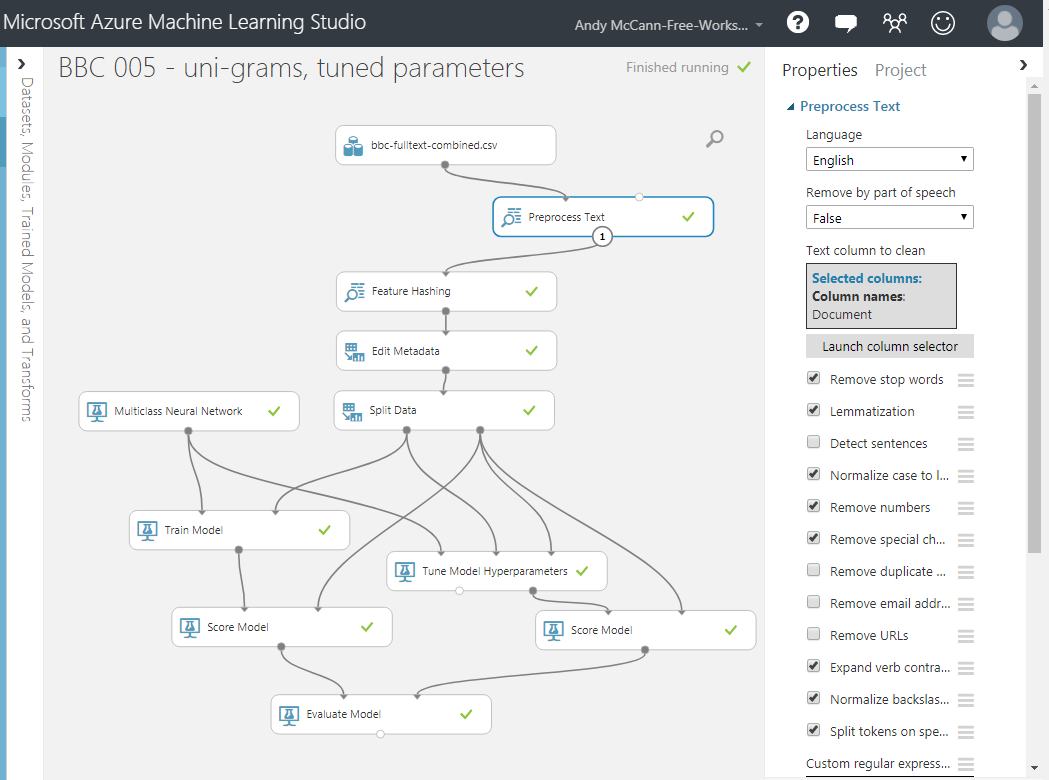

A Multiclass Neural Network with default parameters achieved a 96.4% overall accuracy (micro-averaged F-score).  Tuning these parameters with a 20-pass random sweep improved the accuracy to 97.1%, exactly the same as the linear SVM model in R.

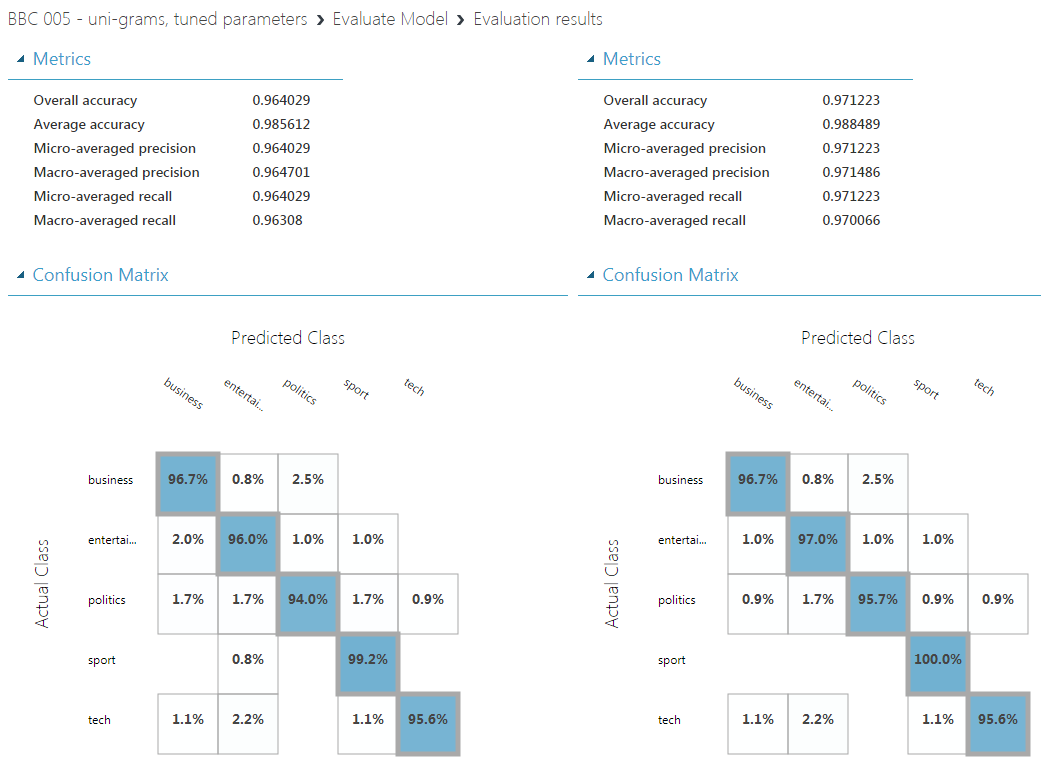

### Live model deployed

The dataset on which this model was built is of BBC news articles from 2004-2005.  As such, the trained model will not be ideal for classifying more recent articles.  For instance, the politicians, sports and entertainment stars from over a decade ago wil not be the same as the ones cited now. 

However, as an exercise, the model has been deployed on a web-site, using an API created by AML.  It can be tested by pasting articles into the following webpage:

https://bbcamcclassificationdemo.azurewebsites.net/

(though please note that, although this is developed using Microsoft tools, in Internet Explorer it seems to always return 'Sport' even though in Chrome it works fine!)